In [1]:
import os, sys, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)

import numpy as np
np.random.seed(1004)   # for reproducibility
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
%matplotlib inline
from scipy.misc import imresize

import pandas as pd
import h5py

from lasagne import layers, nonlinearities, updates, objectives, init, regularization
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
#from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams


Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [ ]:
"""



datapath='/home/peter/Data/CMAP/training.csv'
savepath='/home/peter/Data/CMAP/dataset.hd5f'

batch_size = 20000
shuffle_index = np.random.permutation(100000)
for i in range(1,5):
    batch_index =range(i*batch_size, (i+1)*batch_size)
    data = pd.read_csv(datapath, usecols=shuffle_index[batch_index], header=None, dtype=np.float32)
    genes = data.as_matrix()
    num_landmark = 970
    num_nonlandmark = 11350
    num_samples = genes.shape[1]
    landmark = genes[:970,:]
    nonlandmark = genes[970:,:]
    del genes

    f = h5py.File(savepath, "a")
    dset = f.create_dataset("landmark"+str(i), data=landmark)
    dset = f.create_dataset("nonlandmark"+str(i), data=nonlandmark)
    del landmark
    del nonlandmark
f.close()

In [ ]:

"""
def normalize_data(landmark, nonlandmark, mean_landmark, std_landmark, mean_nonlandmark, std_nonlandmark, num_samples):
    landmark = (landmark - np.outer(mean_landmark,np.ones(num_samples)))/np.outer(std_landmark,np.ones(num_samples))
    nonlandmark = (nonlandmark - np.outer(mean_nonlandmark,np.ones(num_samples)))/np.outer(std_nonlandmark,np.ones(num_samples))
    landmark = landmark.transpose([1,0])
    nonlandmark = nonlandmark.transpose([1,0])

    return landmark, nonlandmark


filepath='/home/peter/Data/CMAP/dataset.hd5f'
trainmat = h5py.File(filepath, 'r')
landmark= np.array(trainmat['landmark1']).astype(np.float32)
nonlandmark = np.array(trainmat['nonlandmark1']).astype(np.float32)

num_files = 5
mean_landmark = 0
std_landmark = 0
mean_nonlandmark = 0
std_nonlandmark = 0
for i in range(num_files):
    landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
    nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
    mean_landmark += np.mean(landmark, axis=1)
    std_landmark += np.std(landmark,axis=1)
    mean_nonlandmark += np.mean(nonlandmark, axis=1)
    std_nonlandmark += np.std(nonlandmark, axis=1)

mean_landmark /= num_files
std_landmark /= num_files
mean_nonlandmark /= num_files
std_nonlandmark /= num_files



savepath='/home/peter/Data/CMAP/dataset_norm.hd5f'
f = h5py.File(savepath, "a")
batch_size = 20000
for i in range(0,5):
    landmark = np.array(trainmat['landmark'+str(i)]).astype(np.float32)
    nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
    landmark, nonlandmark = normalize_data(landmark, nonlandmark, mean_landmark, std_landmark, mean_nonlandmark, std_nonlandmark, num_samples)
    dset = f.create_dataset("landmark"+str(i), data=landmark)
    dset = f.create_dataset("nonlandmark"+str(i), data=nonlandmark)
dset = f.create_dataset("mean_landmark", data=mean_landmark)
dset = f.create_dataset("std_landmark", data=std_landmark)
dset = f.create_dataset("mean_nonlandmark", data=mean_nonlandmark)
dset = f.create_dataset("std_nonlandmark", data=std_nonlandmark)
f.close()


In [2]:
filepath='/home/peter/Data/CMAP/dataset_norm.hd5f'
trainmat = h5py.File(filepath, 'r')
landmark= np.array(trainmat['landmark4']).astype(np.float32)
nonlandmark = np.array(trainmat['nonlandmark4']).astype(np.float32)

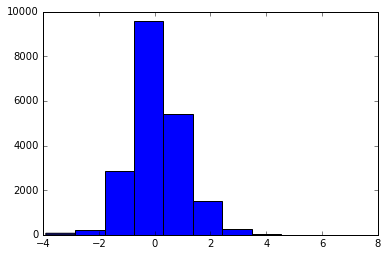

In [3]:
index = 2
plt.hist(landmark[:,index]);

# linear regression

In [ ]:
num_encode=100

input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['dense1'] = layers.DenseLayer(net['input'], num_units=nonlandmark.shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense1_active'] = layers.NonlinearityLayer(net['dense1'], nonlinearity=nonlinearities.linear)
net['output'] = net['dense1_active']

In [ ]:
target_var = T.dmatrix('inputs')
prediction = get_output(net['output'], deterministic=False )
loss = objectives.squared_error(target_var, prediction)
loss = objectives.aggregate(loss, mode='mean')

# ADAM updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], loss , updates=update_op, allow_input_downcast=True)


In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for i in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

Epoch 1 
  File 1 
    training loss:		0.588965
  File 2 
    training loss:		0.599399
  File 3 
    training loss:		0.509065
  File 4 
    training loss:		0.578905
  File 5 
    training loss:		0.566761
  training loss:		0.568619
Epoch 2 
  File 1 
    training loss:		0.464421
  File 2 
    training loss:		0.486734
  File 3 
    training loss:		0.432946
  File 4 
    training loss:		0.476401
  File 5 
    training loss:		0.494727
  training loss:		0.471046
Epoch 3 
  File 1 
    training loss:		0.448270
  File 2 
    training loss:		0.484055
  File 3 
    training loss:		0.431769
  File 4 
    training loss:		0.487850
  File 5 
    training loss:		0.504944
  training loss:		0.471378

# Feed forward network

In [4]:
num_encode=100

input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['dense1'] = layers.DenseLayer(net['input'], num_units=5000, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense1_active'] = layers.NonlinearityLayer(net['dense1'], nonlinearity=nonlinearities.rectify)
#net['dense1_active'] = layers.ParametricRectifierLayer(net['dense1_norm'])
#net['dense1_droput'] = layers.DropoutLayer(net['dense1_active'], p=0.5)


net['dense2'] = layers.DenseLayer(net['dense1_active'], num_units=nonlandmark.shape[1], W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dense2_active'] = layers.NonlinearityLayer(net['dense2'], nonlinearity=nonlinearities.linear)
#net['dense2_active'] = layers.ParametricRectifierLayer(net['dense2_norm'])
#net['dense2_droput'] = layers.DropoutLayer(net['dense2_active'], p=0.5)

net['output'] = net['dense2_active']

In [5]:
target_var = T.dmatrix('inputs')
prediction = get_output(net['output'], deterministic=False )
loss = objectives.squared_error(target_var, prediction)
loss = objectives.aggregate(loss, mode='mean')

#l1_penalty = regularization.regularize_network_params(net, regularization.l1) * 1e-5
#loss += l1_penalty
#l2_penalty = regularization.regularize_network_params(net, regularization.l2) * 1e-6    
#loss += l2_penalty 
    
# ADAM updates
params = get_all_params(net['output'], trainable=True)
update_op = updates.adam(loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], loss , updates=update_op, allow_input_downcast=True)

In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for i in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

Epoch 1 
  File 1 
    training loss:		1.121686
  File 2 
    training loss:		2.193375
  File 3 
    training loss:		11.844916
  File 4 
    training loss:		4.190112
  File 5 
    training loss:		1.010566
  training loss:		4.072131
Epoch 2 
  File 1 
    training loss:		203.215020
  File 2 


# Variational autoencoder

In [ ]:
class VariationalSampleLayer(layers.MergeLayer):
    def __init__(self, incoming_mu, incoming_logsigma, **kwargs):
        super(VariationalSampleLayer, self).__init__(incomings=[incoming_mu, incoming_logsigma], **kwargs)
        self.srng = RandomStreams(seed=234)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.srng.normal(shape, avg=0.0, std=1).astype(theano.config.floatX)


In [ ]:
num_encode=100

input_var = T.dmatrix('inputs')
shape = (None, landmark.shape[1])
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['encode1'] = layers.DenseLayer(net['input'], num_units=600, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode1_active'] = layers.NonlinearityLayer(net['encode1'], nonlinearity=nonlinearities.rectify)
#net['encode1_active'] = layers.ParametricRectifierLayer(net['encode1_norm'])
net['encode1_dropout'] = layers.DropoutLayer(net['encode1_active'], p=0.5)

net['encode2'] = layers.DenseLayer(net['encode1_dropout'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
#net['encode2_norm'] = layers.BatchNormLayer(net['encode2'])
net['encode2_active'] = layers.NonlinearityLayer(net['encode2'], nonlinearity=nonlinearities.rectify)
#net['encode2_active'] = layers.ParametricRectifierLayer(net['encode2_norm'])
net['encode2_dropout'] = layers.DropoutLayer(net['encode2_active'], p=0.5)


net['encode_mu'] = layers.DenseLayer(net['encode2_dropout'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2_dropout'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])


net['dencode1'] = layers.DenseLayer(net['Z'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
#net['dencode1_norm'] = layers.BatchNormLayer(net['dencode1'])
net['dencode1_active'] = layers.NonlinearityLayer(net['dencode1'], nonlinearity=nonlinearities.rectify)
#net['dencode1_active'] = layers.ParametricRectifierLayer(net['dencode1_norm'])
net['dencode1_dropout'] = layers.DropoutLayer(net['dencode1_active'], p=0.5)


net['dencode2'] = layers.DenseLayer(net['dencode1_dropout'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
#net['dencode2_norm'] = layers.BatchNormLayer(net['dencode2'])
net['dencode2_active'] = layers.NonlinearityLayer(net['dencode2'], nonlinearity=nonlinearities.rectify)
#net['dencode2_active'] = layers.ParametricRectifierLayer(net['dencode2_norm'])
net['dencode2_dropout'] = layers.DropoutLayer(net['dencode2_active'], p=0.5)


net['X'] = layers.DenseLayer(net['dencode2_dropout'], num_units=nonlandmark.shape[1],  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])

In [ ]:
def build_loss(net, target_var, deterministic):
    z_mu = get_output(net['encode_mu'], deterministic=deterministic)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=deterministic)
    x_mu = get_output(net['X'], deterministic=deterministic)
    #x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = 1.# use real std   
    kl_divergence = 0.5*T.sum(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma), axis=1)
    log_likelihood = T.sum(-0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma),axis=1)
    variational_lower_bound = -log_likelihood - kl_divergence
    prediction = x_mu
    return variational_lower_bound.mean()

target_var = T.dmatrix('inputs')
train_loss = build_loss(net, target_var, deterministic=False)
test_loss = build_loss(net, target_var, deterministic=True)

# ADAM updates
params = get_all_params(net['X'], trainable=True)
update_op = updates.adam(train_loss, params, learning_rate=1e-3)

train_fun = theano.function([input_var, target_var], train_loss , updates=update_op, allow_input_downcast=True)
valid_fun = theano.function([input_var, target_var], test_loss, allow_input_downcast=True)

In [ ]:
def batch_generator(X, y, batch_size=128):
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt], y[excerpt]

batch_size = 100        
num_samples = 20000
num_files = 5        
num_epochs = 60    
num_batches = num_samples // batch_size
for epoch in range(num_epochs):
    sys.stdout.write("\rEpoch %d \n"%(epoch+1))

    train_loss = 0
    for i in range(num_files):
        sys.stdout.write("\r  File %d \n"%(i+1))
        landmark= np.array(trainmat['landmark'+str(i)]).astype(np.float32)
        nonlandmark = np.array(trainmat['nonlandmark'+str(i)]).astype(np.float32)
        landmark, nonlandmark = normalize_data(landmark, nonlandmark, mean_landmark, std_landmark, mean_nonlandmark, std_nonlandmark, num_samples)
        batches = batch_generator(landmark, nonlandmark, batch_size)
        
        loss = 0
        for i in range(num_batches):
            X, y = next(batches)
            loss += train_fun(X, y)
        print("    training loss:\t\t{:.6f}".format(loss/num_batches))    
        train_loss += loss/num_batches              
    train_loss /= num_files
    print("  training loss:\t\t{:.6f}".format(train_loss))

In [ ]:
def statistics(net, target_var):
    z_mu = get_output(net['encode_mu'], deterministic=True)
    z_logsigma = get_output(net['encode_logsigma'], deterministic=True)
    x_mu = get_output(net['X'], deterministic=True)
    x_mu = T.clip(x_mu, 1e-7, 1-1e-7)
    x_logsigma = T.log(T.sqrt(x_mu*(1-x_mu)))
    kl_divergence = 0.5*(1 + 2*z_logsigma - T.sqr(z_mu) - T.exp(2*z_logsigma))
    log_likelihood = -0.5*T.log(2*np.float32(np.pi))- x_logsigma - 0.5*T.sqr(target_var-x_mu)/T.exp(2*x_logsigma)
    return kl_divergence, log_likelihood

kl_divergence, log_likelihood = statistics(net, input_var)
statistics_fun = theano.function([input_var],[kl_divergence, log_likelihood])

In [ ]:
batch_size = 25
num_test_batches = X_valid.shape[0] // batch_size
test_batches = batch_generator(X_valid, batch_size, shuffle=False)

kldiv = []
logL = []
for index in range(num_test_batches):
    stats = statistics_fun(next(test_batches))
    kldiv.append(stats[0])
    logL.append(stats[1])

kldiv = np.array(kldiv).reshape([-1,stats[0].shape[1]])
logL = np.array(logL).reshape([-1,stats[1].shape[1]])

In [ ]:
plt.figure
plt.errorbar(range(num_encode),-np.mean(kldiv,axis=0),np.std(kldiv,axis=0), fmt='o', markersize=12)
plt.xlim([-.3, num_encode-.7])
plt.xlabel('z', fontsize=18)
plt.ylabel('-KLD', fontsize=18)
#plt.yticks([0, 1, 2, 3], fontsize = 18)
plt.xticks(fontsize = 18)
plt.savefig('Genes_vae_kldivergence_'+ str(num_encode) +'.eps', format='eps', dpi=200)

# denoising autoencoder

In [ ]:
num_encode=100

input_var = T.dmatrix('inputs')
shape = (None, num_landmark)
net = {}
net['input'] = layers.InputLayer(shape=shape, input_var=input_var)
net['corrupt1'] = layers.GaussianNoiseLayer(net['input'], sigma=0.1)
net['encode1'] = layers.DenseLayer(net['corrupt1'], num_units=600, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode1_active'] = layers.NonlinearityLayer(net['encode1'], nonlinearity=nonlinearities.rectify)
#net['encode1_active'] = layers.ParametricRectifierLayer(net['encode1_norm'])


net['corrupt2'] = layers.GaussianNoiseLayer(net['encode1_active'], sigma=0.1)
net['encode2'] = layers.DenseLayer(net['corrupt2'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['encode2_active'] = layers.NonlinearityLayer(net['encode2'], nonlinearity=nonlinearities.rectify)
#net['encode2_active'] = layers.ParametricRectifierLayer(net['encode2_norm'])

net['encode_mu'] = layers.DenseLayer(net['encode2_dropout'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['encode_logsigma'] = layers.DenseLayer(net['encode2_dropout'], num_units=num_encode, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
net['Z'] = VariationalSampleLayer(net['encode_mu'], net['encode_logsigma'])


net['corrupt3'] = layers.GaussianNoiseLayer(net['Z'], sigma=0.1)
net['dencode1'] = layers.DenseLayer(net['corrupt3'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dencode1_active'] = layers.NonlinearityLayer(net['dencode1'], nonlinearity=nonlinearities.rectify)
#net['dencode1_active'] = layers.ParametricRectifierLayer(net['dencode1_norm'])


net['corrupt4'] = layers.GaussianNoiseLayer(net['dencode1_active'], sigma=0.1)
net['dencode2'] = layers.DenseLayer(net['corrupt4'], num_units=300, W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=None)
net['dencode2_active'] = layers.NonlinearityLayer(net['dencode2'], nonlinearity=nonlinearities.rectify)
#net['dencode2_active'] = layers.ParametricRectifierLayer(net['dencode2_norm'])


net['X'] = layers.DenseLayer(net['dencode2_dropout'], num_units=num_nonlandmark,  W=init.GlorotUniform(), 
                                  b=init.Constant(.0), nonlinearity=nonlinearities.linear)
#net['decode_logsigma'] = layers.DenseLayer(net['decode2'], num_units=x_dim, nonlinearity=nonlinearities.linear)
#net['X'] = VariationalSampleLayer(net['decode_mu'], net['decode_logsigma'])